In [1]:
import os
import yaml
import datetime
import numpy as np
import matplotlib.pyplot as plt

from AgeNet import environments, physics, Agent, AgentsSimulator
from AgeNet import analyses, experiments
from AgeNet.learning import RLBrain


In [2]:
# 1. Environment ------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------
L = 14                                  # The length of the simulation box
buildings_type = "random"               # Type of placement of buildings (random or regular)
num_buildings  = 00                     # Number of buildings in environment
num_streets    = 0                      # Number of streets in environment

sumo_cfg    = "./Sumo/SumoScenario/simulation.sumocfg"
sumo_binary = "/nix/store/gp4hbfbrxg4zzjs7g3nl7vy0rw4jmm2y-sumo-1.22.0/bin/sumo"
step_length = 1.0                       # 
use_gui     = False                     # 
sumo_seed   = None                      # 

environment_parameters = [L, buildings_type, num_buildings, num_streets]            # manual env
# environment_parameters = [sumo_cfg, sumo_binary, step_length, use_gui, sumo_seed]   # sumo env


# 2. Agent Learning ---------------------------------------------------------------------
# ---------------------------------------------------------------------------------------
N = 100                                 # Number of agents
Alphas = [-0.5, 0.1, 0.2, -0.5]       # Hamiltonian constant coefficients

state_dim     = 3                       # Dimensions of the agent state for neural network input
action_dim    = 2                       # Neural network output dimensions (Q values)
learning_rate = 1e-5                    # Learning rate in model training
discount_rate = 0.98                    # The effect of future decisions on current decisions
batch_size    = 20                      # Selected package of replay_memory to perform training
steps_per_train = 10                    # The training function is called once every ... steps
Initialize_model_path = f'./Trained Models/20260213-161716/model_minHamiltonian.keras'
brain_parameters = [state_dim, action_dim, learning_rate, discount_rate, batch_size, Initialize_model_path]


# 3. Communication ----------------------------------------------------------------------
# ---------------------------------------------------------------------------------------
absorption  = 0.5
base_delay  = 0.01
max_delay   = 1.0
communication_parameters = [absorption, base_delay, max_delay]


# 4. Action Policy ----------------------------------------------------------------------
# ---------------------------------------------------------------------------------------
action_policy_type = 'kNN'               # FR or kNN or MD or RL
action_k_min = 5
policy_parameters = [action_policy_type, action_k_min]


# 5. Functions --------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------
moving     = False                       # Enable the move function to agents
requesting = False                       # Enable the sending request function
training   = False                       # Enable each agent model training function
Functions  = [moving, requesting, training]


# 6. Directory and Seed -----------------------------------------------------------------
# ---------------------------------------------------------------------------------------
log_dir = f"Results/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
seed = 30
np.random.seed(seed)



# Configs -------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------
config = {
    "environment": environment_parameters,

    'number of agent': N,
    "brain": brain_parameters,
    'alpha': Alphas,
    'communication': communication_parameters,
    'action policy': policy_parameters,
    'functions': Functions,
    'seed': seed
}



### main runs

In [3]:
def main(config, log_dir):
    # Parameters ------------------------------------------------------------------------------------
    N                        = config['number of agent']
    environment_parameters   = config['environment']
    brain_parameters         = config['brain']
    Alphas                   = config['alpha']
    communication_parameters = config['communication']
    policy_parameters        = config['action policy']
    Functions                = config['functions']
    seed                     = config['seed']

    # Init ------------------------------------------------------------------------------------------
    np.random.seed(seed)
    environment = environments.SimpleEnvironment(*environment_parameters)

    Agents = []
    for i in range(N): 
        physical_state = physics.PhysicalState(environment, f'{i}')
        movement       = physics.NonMarkovian(environment)
        agent = Agent(f'{i}', Alphas, brain_parameters, communication_parameters, physical_state, movement, policy_parameters)
        Agents.append(agent)

    simulator  = AgentsSimulator(environment, Agents, Functions)
    # visualizer = analyses.NetworkVisualizer(environment)
    result_exporter = experiments.ResultExporter(environment)
    # result_ploter   = experiments.ResultPloter(log_dir, environment)


    # Run -------------------------------------------------------------------------------------------
    for step in range(1001):
        simulator.run(Agents, steps_per_train=10)

        # -------------------------------------------------------------------------------------------
        result_exporter.collect(step, Agents)
        # if step%5 == 0: visualizer.draw(Agents, step)
        print("\rStep: {}".format(step), end="")

    if not os.path.exists(log_dir): os.makedirs(log_dir)

    result_exporter.export_excel(f'./{log_dir}', f'{seed}, Policy Type = {policy_parameters[0]}, Requesting = {Functions[1]}')
    # result_ploter.average_result(result_exporter.averaged_results)
    # anim = visualizer.camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=False)
    # anim.save(f'./{log_dir}/Animation.gif')
    with open(f"{log_dir}/config.yaml", "w") as f: yaml.dump(config, f, sort_keys=False)
    

In [ ]:
Functions_ = [ [True, False, False], [True, False, True], [True, True, True] ]  # [moving, requesting, training]
Policy_Parameters_ = [ ['MD', 5], ['RL', 1], ['RL', 1] ]                        # [action_policy_type, action_k_min]
log_dir = './kNN/Static'

for seed in range(30, 50):
    # for init in range(3):
    #     Functions = Functions_[init]
    #     policy_parameters = Policy_Parameters_[init]

        config = config = {
            "environment": environment_parameters,

            'number of agent': N,
            "brain": brain_parameters,
            'alpha': Alphas,
            'communication': communication_parameters,
            'action policy': policy_parameters,
            
            'functions': Functions,
            'seed': seed
        }

        main(config, log_dir)
        print(f'\t seed = {seed}, Policy Type = {policy_parameters[0]}, Requesting = {Functions[1]}')
    

### learning

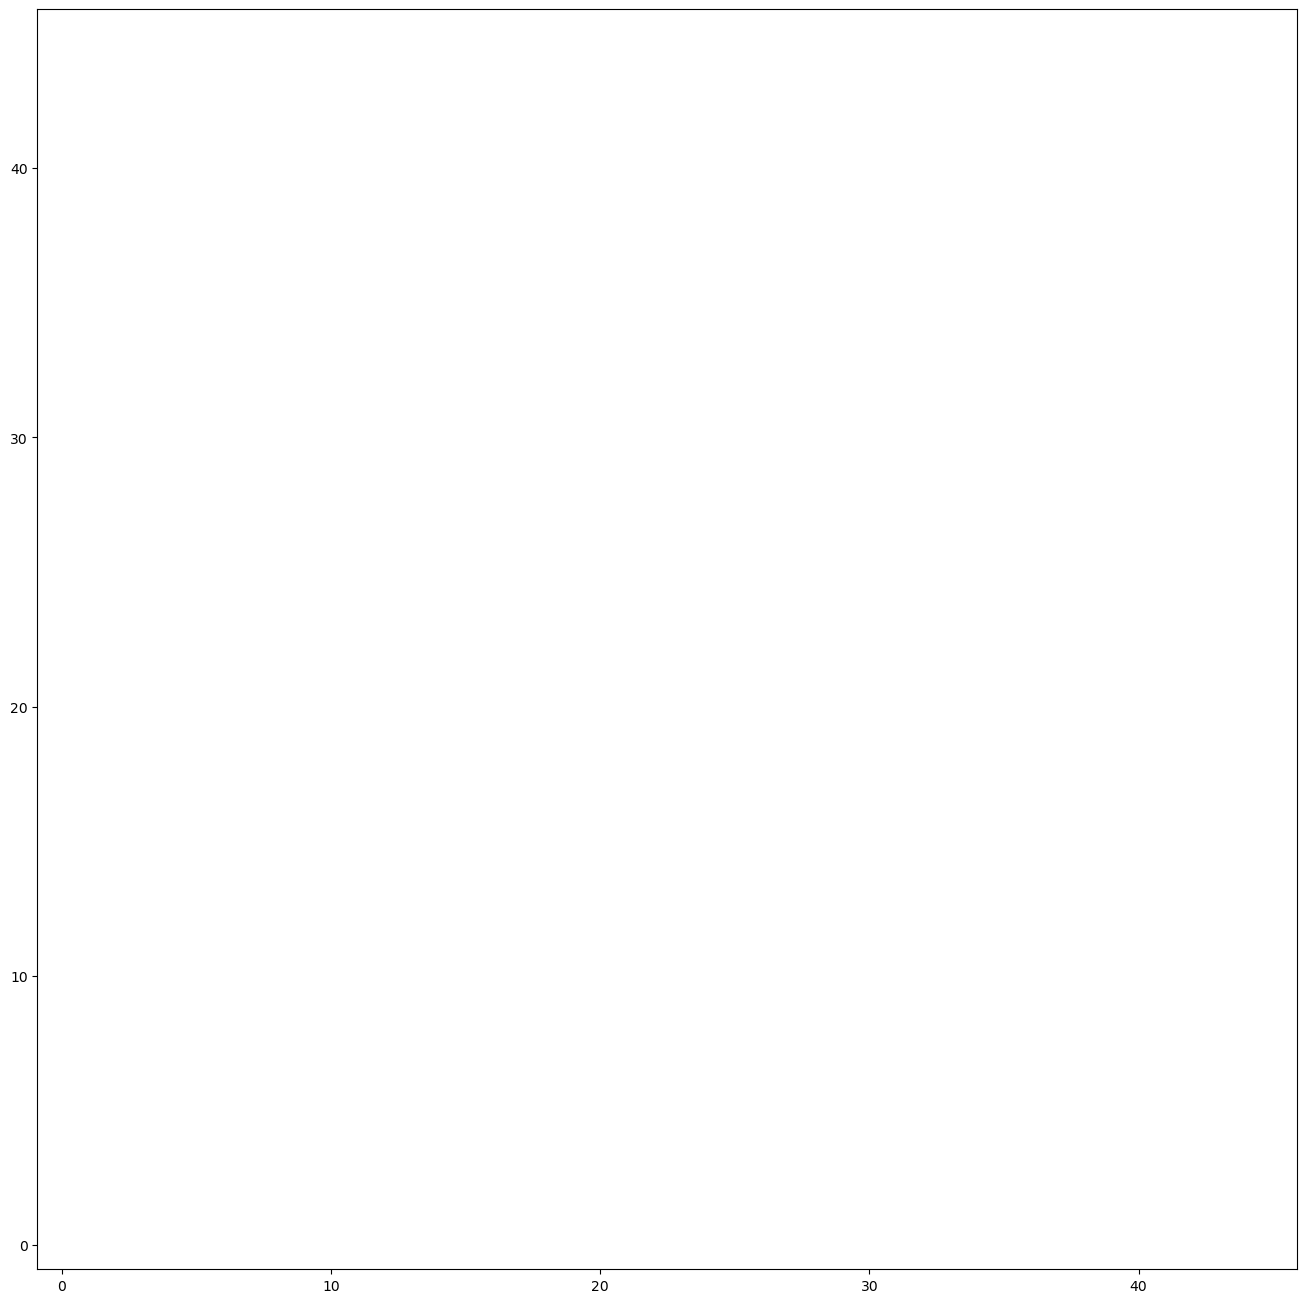

In [ ]:
brain_parameters = [state_dim, action_dim, learning_rate, discount_rate, batch_size]
brain = RLBrain(*brain_parameters)

environment = environments.SimpleEnvironment(*environment_parameters)

Agents: list[Agent] = []
for i in range(N): 
    physical_state = physics.PhysicalState(environment, f'{i}')
    movement       = physics.NonMarkovian(environment)
    agent = Agent(f'{i}', Alphas, brain_parameters, communication_parameters, physical_state, movement)
    agent.brain = brain
    Agents.append(agent)

Functions  = [False, False, training]
simulator  = AgentsSimulator(environment, Agents, Functions)

visualizer = analyses.NetworkVisualizer(environment)
result_exporter = experiments.ResultExporter(environment)
result_ploter   = experiments.ResultPloter(log_dir, environment)


In [ ]:
best_H, best_G, best_H2G2 = 0, 0, 0
for step in range(1001):
    simulator.run(Agents, steps_per_train=1)

    # -------------------------------------------------------------------------------------------
    result_exporter.collect(step, Agents)
    if step%5 == 0: visualizer.draw(Agents, step)
    print("\rStep: {}".format(step), end="")

    # Find Best Weights ------------------------------------------------------------------------- 
    step, hamilton, giant, _, _, _, _ = result_exporter.averaged_results[-1]    
    if step > 500:
        if hamilton <= best_H:                                  # find the minimum of Hamiltonian
            H_best_weight    = Agents[0].model.get_weights()    # saving model weights for the best Hamiltonian
            best_H = hamilton

        if giant >= best_G:
            G_best_weight    = Agents[0].model.get_weights()    # saving model weights for the best Giant Component
            best_G = giant

        if np.sqrt(hamilton**2 + (giant/1e3)**2) >= best_H2G2:
            H2G2_best_weight = Agents[0].model.get_weights()
            best_H2G2 = np.sqrt(hamilton**2 + (giant/1e3)**2)


if not os.path.exists(log_dir): os.makedirs(log_dir)

anim = visualizer.camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=False)
result_exporter.export_excel(f'./{log_dir}')
result_ploter.average_result(result_exporter.averaged_results)
anim.save(f'./{log_dir}/Animation - Training.gif')
with open(f"{log_dir}/config.yaml", "w") as f: yaml.dump(config, f, sort_keys=False)


last_weight = Agents[0].model.get_weights()

best_models = [H_best_weight, G_best_weight, H2G2_best_weight, last_weight]
best_models_name = ['minHamiltonian', 'maxConnectivity', 'balancedHG', 'FinalStep']
for i, best_model in enumerate(best_models):
    model_ = Agents[0].model
    model_.set_weights(best_model)
    model_.save(f'{log_dir}/model_{best_models_name[i]}.keras')
    

### classical algorithem

In [ ]:
environment = environments.SimpleEnvironment(*environment_parameters)

Agents = []
for i in range(N): 
    physical_state = physics.PhysicalState(environment, f'{i}')
    movement       = physics.NonMarkovian(environment)
    agent = Agent(f'{i}', Alphas, brain_parameters, communication_parameters, physical_state, movement, policy_parameters)
    Agents.append(agent)

Functions  = [moving, False, False]
simulator  = AgentsSimulator(environment, Agents, Functions)

visualizer = analyses.NetworkVisualizer(environment)
result_exporter = experiments.ResultExporter(environment)
result_ploter   = experiments.ResultPloter(log_dir, environment)


In [ ]:
for step in range(1001):
    simulator.run(Agents)

    # -------------------------------------------------------------------------------------------
    result_exporter.collect(step, Agents)
    if step%5 == 0: visualizer.draw(Agents, step)
    print("\rStep: {}".format(step), end="")


if not os.path.exists(log_dir): os.makedirs(log_dir)

anim = visualizer.camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=False)
result_exporter.export_excel(f'./{log_dir}')
result_ploter.average_result(result_exporter.averaged_results)
anim.save(f'./{log_dir}/Animation.gif')


### Simple Environment

In [ ]:
environment = environments.SimpleEnvironment(*environment_parameters)

Agents = []
for i in range(N): 
    physical_state = physics.PhysicalState(environment, f'{i}')
    movement       = physics.NonMarkovian(environment)
    agent = Agent(f'{i}', Alphas, brain_parameters, communication_parameters, physical_state, movement)
    Agents.append(agent)

simulator  = AgentsSimulator(environment, Agents, Functions)

visualizer = analyses.NetworkVisualizer(environment)
result_exporter = experiments.ResultExporter(environment)
result_ploter   = experiments.ResultPloter(log_dir, environment)


In [ ]:
for step in range(1001):
    simulator.run(Agents, steps_per_train=10)

    # -------------------------------------------------------------------------------------------
    result_exporter.collect(step, Agents)
    if step%5 == 0: visualizer.draw(Agents, step)
    print("\rStep: {}".format(step), end="")

if not os.path.exists(log_dir): os.makedirs(log_dir)

anim = visualizer.camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=False)
result_exporter.export_excel(f'./{log_dir}')
result_ploter.average_result(result_exporter.averaged_results)
anim.save(f'./{log_dir}/Animation.gif')


### Sumo Environment

In [ ]:
environment = environments.SumoEnvironment(*environment_parameters)
environment.start()

Agents = []

simulator  = AgentsSimulator(environment, Agents, Functions)
visualizer = analyses.NetworkVisualizer(environment)
result_exporter = experiments.ResultExporter(environment)
result_ploter   = experiments.ResultPloter(log_dir, environment)


In [ ]:
ids, ids_prev = [], []

for step in range(1001):
    environment.step()
    ids      = environment.get_entity_ids()
    new_ids  = list(set(ids) - set(ids_prev))
    del_ids  = list(set(ids_prev) - set(ids))
    ids_prev = ids

    for id in new_ids:
        physical_state = physics.PhysicalState(environment, id)
        agent = Agent(id, Alphas, brain_parameters, communication_parameters, physical_state)
        Agents.append(agent)
        simulator.add_agent(agent, Functions)

    for id in del_ids:
        removed_agent = next((agent for agent in Agents if agent.id == id), None)
        Agents.remove(removed_agent)
        simulator.remove_agent(removed_agent)
    

    simulator.run(Agents, steps_per_train=10)
    
    # -------------------------------------------------------------------------------------------
    if len(ids) > 1:
        result_exporter.collect(step, Agents)
        if step%5 == 0: visualizer.draw(Agents, step)
    print("\rStep: {}".format(step), end="")

environment.close()
if not os.path.exists(log_dir): os.makedirs(log_dir)

anim = visualizer.camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=False)
result_exporter.export_excel(f'./{log_dir}')
result_ploter.average_result(result_exporter.averaged_results)
anim.save(f'./{log_dir}/test.gif')

d:\Applications\Anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input. Received: the structure of inputs={'input': '*'}
  warnings.warn(


Step: 1000

### Tests

In [ ]:
def initializer(
        environment_type:           str, 
        environment_parameters:     list,
        brain_parameters:           list,
        communication_parameters:   list = [0.5, 0.01, 1.0],
        policy_parameters:          list = ['RL'],
        Alphas:                     list = [-0.5, +0.3, 1.0, -1000],
        Functions:                  list = [True, True, True],
        N:                          int = 100,
        log_dir:                    str = './'
        
        ):
    
    Agents = []

    if environment_type == 'manual':
        environment = environments.SimpleEnvironment(*environment_parameters)
        for i in range(N): 
            physical_state = physics.PhysicalState(environment, f'{i}')
            movement       = physics.NonMarkovian(environment)
            agent = Agent(f'{i}', Alphas, brain_parameters, communication_parameters, physical_state, movement, policy_parameters)
            Agents.append(agent)

    elif environment_type == 'sumo':
        environment = environments.SumoEnvironment(*environment_parameters)
        environment.start()


    simulator  = AgentsSimulator(environment, Agents, Functions)
    visualizer = analyses.NetworkVisualizer(environment)
    result_exporter = experiments.ResultExporter(environment)
    result_ploter   = experiments.ResultPloter(log_dir, environment)

    return environment, Agents, simulator, visualizer, result_exporter, result_ploter


In [ ]:
def initializer(
        environment_parameters:     list,
        brain_parameters:           list,
        communication_parameters:   list = [0.5, 0.01, 1.0],
        policy_parameters:          list = ['RL'],
        Alphas:                     list = [-0.5, +0.3, 1.0, -1000],
        Functions:                  list = [True, True, True],
        learning:                   bool = False,
        N:                          int = 100,
        log_dir:                    str = './'
        
        ):
    
    environment = environments.SimpleEnvironment(*environment_parameters)
    brain = RLBrain(*brain_parameters)

    Agents = []
    for i in range(N): 
        physical_state = physics.PhysicalState(environment, f'{i}')
        movement       = physics.NonMarkovian(environment)
        agent = Agent(f'{i}', Alphas, brain_parameters, communication_parameters, physical_state, movement, policy_parameters)
        if learning: agent.brain = brain
        Agents.append(agent)


    simulator  = AgentsSimulator(environment, Agents, Functions)
    visualizer = analyses.NetworkVisualizer(environment)
    result_exporter = experiments.ResultExporter(environment)
    result_ploter   = experiments.ResultPloter(log_dir, environment)

    return environment, Agents, simulator, visualizer, result_exporter, result_ploter


In [ ]:
def main(config, log_dir):
    N                        = config['number of agent']
    environment_parameters   = config['environment']
    brain_parameters         = config['brain']
    Alphas                   = config['alpha']
    communication_parameters = config['communication']
    policy_parameters        = config['action policy']
    Functions                = config['functions']
    seed                     = config['seed']

    # Init -------------------------------------------------------------------------------------------
    np.random.seed(seed)
    environment = environments.SimpleEnvironment(*environment_parameters)

    Agents = []
    for i in range(N): 
        physical_state = physics.PhysicalState(environment, f'{i}')
        movement       = physics.NonMarkovian(environment)
        agent = Agent(f'{i}', Alphas, brain_parameters, communication_parameters, physical_state, movement, policy_parameters)
        Agents.append(agent)

    simulator  = AgentsSimulator(environment, Agents, Functions)
    visualizer = analyses.NetworkVisualizer(environment)
    result_exporter = experiments.ResultExporter(environment)
    result_ploter   = experiments.ResultPloter(log_dir, environment)


    # Run -------------------------------------------------------------------------------------------
    for step in range(1001):
        simulator.run(Agents, steps_per_train=10)

        # -------------------------------------------------------------------------------------------
        result_exporter.collect(step, Agents)
        if step%5 == 0: visualizer.draw(Agents, step)
        print("\rStep: {}".format(step), end="")

    if not os.path.exists(log_dir): os.makedirs(log_dir)

    result_exporter.export_excel(f'./{log_dir}')
    result_ploter.average_result(result_exporter.averaged_results)
    anim = visualizer.camera.animate(interval= 120, repeat=True, repeat_delay= 500, blit=False)
    anim.save(f'./{log_dir}/Animation.gif')
    with open(f"{log_dir}/config.yaml", "w") as f: yaml.dump(config, f, sort_keys=False)
    

In [ ]:
sumo_binary = "/nix/store/gp4hbfbrxg4zzjs7g3nl7vy0rw4jmm2y-sumo-1.22.0/bin/sumo"
env = environments.SumoEnvironment("./Sumo/SumoScenario/simulation.sumocfg", sumo_binary, use_gui=False)
env.start()

T = 2001

for t in range(T):
    env.step()
    ids = env.get_entity_ids()
    for vid in ids:
        pos = env.get_position(vid)
    print(t, '\t', ids)

env.close()

In [17]:
delta_H = -50

x = np.clip(-delta_H / 4, -20, 2)  # flip
x = np.clip(-delta_H * 4, -20, 2)  # send request
p = np.exp(x)
p



7.38905609893065

In [3]:
import pstats


cProfile = './Saved Model/cProFile/cProFile.prof'
p = pstats.Stats(cProfile)
p.sort_stats("cumulative").print_stats(30)

Thu Jan  8 20:47:30 2026    ./Saved Model/cProFile/cProFile.prof

         2252379687 function calls (2174567748 primitive calls) in 4202.339 seconds

   Ordered by: cumulative time
   List reduced from 2690 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 10885000  744.331    0.000  744.353    0.000 {built-in method tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute}
  2804100    3.724    0.000  412.780    0.000 d:\Applications\Anaconda3\Lib\site-packages\tensorflow\python\framework\tensor_conversion.py:96(convert_to_tensor_v2_with_dispatch)
  2804100    4.246    0.000  408.998    0.000 d:\Applications\Anaconda3\Lib\site-packages\tensorflow\python\framework\tensor_conversion.py:166(convert_to_tensor_v2)
  2181200    2.791    0.000  302.939    0.000 d:\Applications\Anaconda3\Lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:2374(_dense_var_to_tensor)
  2181200    3.407    0.000  300.126    0.000 d:\Applications\Ana